# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 6 - RNNs



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [80]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [82]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

<div class="theme"> Part 1: Data </div>
Read `HW6_data.csv` into a pandas dataframe using the provided code below.

In [5]:
# Given code
path_dataset = './data/HW6_data.csv'
data = pd.read_csv(path_dataset,
                   encoding="latin1")
data = data.fillna(method="ffill")
print(data.shape)
data.head(15)

(1048575, 4)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<div class='exercise'><b> Question 1: Data [20 points total]</b></div>

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
 
**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

**1.12** Split the dataset into train and test sets (test 10%).

## Answers

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

In [6]:
word_extract = list(data.Word)
words = list(set(word_extract))
words.sort()
words.append("ENDPAD")
n_words = len(words)

In [7]:
# Run this cell to show your results for n_words
print(n_words)

35179


**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

In [8]:
tag_extract = list(data.Tag)
tags = list(set(tag_extract))
tags.sort()
tags.append("PAD")
n_tags = len(tags)

In [9]:
# Run this cell to show your results for n_tags
print(n_tags)

18


**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 

In [9]:
data['word_tag'] = list(zip(data.Word, data.Tag)) # create tuple of words and tags
data.head()

,Sentence #,Word,POS,Tag,word_tag
0,Sentence: 1,Thousands,NNS,O,"(Thousands, O)"
1,Sentence: 1,of,IN,O,"(of, O)"
2,Sentence: 1,demonstrators,NNS,O,"(demonstrators, O)"
3,Sentence: 1,have,VBP,O,"(have, O)"
4,Sentence: 1,marched,VBN,O,"(marched, O)"


In [10]:
sent_tag_list = data.word_tag.groupby(data['Sentence #']).apply(list)
print(f'Length of the list: {len(sent_tag_list)}\n')
print(f'First sentence:\n {(sent_tag_list[0])}')

Length of the list: 47959

First sentence:
 [('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

In [10]:
max_len = data['Sentence #'].value_counts().sort_values(ascending = False)[0]

In [11]:
# Run this cell to show your results for max_len
print(max_len)

104


**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

In [12]:
word2idx = dict(zip(words, range(len(words))))
print(f'Length of idx2word: {len(word2idx)}')
print(f'1st 10 items in the dictionary: {list(word2idx.items())[:10]}')

Length of idx2word: 35179
1st 10 items in the dictionary: [('!', 0), ('"', 1), ('#', 2), ('#NAME?', 3), ('$', 4), ('%', 5), ('%-plus', 6), ('&', 7), ("'", 8), ("'70s", 9)]


In [13]:
idx2word = dict(enumerate(words))
print(f'Length of word2idx: {len(idx2word)}')
print(f'1st 10 items in the dictionary: {list(idx2word.items())[:10]}')

Length of word2idx: 35179
1st 10 items in the dictionary: [(0, '!'), (1, '"'), (2, '#'), (3, '#NAME?'), (4, '$'), (5, '%'), (6, '%-plus'), (7, '&'), (8, "'"), (9, "'70s")]


**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

In [14]:
sent_word_list = list(data['Word'].groupby(data['Sentence #']).apply(list)) # create list of lists for sentences
temp_check = len(sent_word_list) == len(data['Sentence #'].value_counts())
print(f'Length equals number of sentences in provided df: {temp_check}')

print(f'1st sentence below: \n{sent_word_list[1]}')

Length equals number of sentences in provided df: True
1st sentence below: 
['Iranian', 'officials', 'say', 'they', 'expect', 'to', 'get', 'access', 'to', 'sealed', 'sensitive', 'parts', 'of', 'the', 'plant', 'Wednesday', ',', 'after', 'an', 'IAEA', 'surveillance', 'system', 'begins', 'functioning', '.']


In [15]:
x = []
for i in range(len(sent_word_list)):
    # get index values from word2idx dictionary and append to a list
    x.append(list(map(word2idx.get, sent_word_list[i])))

X = x.copy() # Predictor matrix

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`

In [16]:
X = pad_sequences(x, maxlen = max_len, padding = 'post', value = len(words)-1)

In [17]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

In [18]:
tag2idx = dict(zip(tags, range(len(tags))))
print(f'Length of tag2idx: {len(tag2idx)}')
print(f'1st 10 items in the dictionary: {list(tag2idx.items())[:10]}\n')

idx2tag = dict(zip(range(len(tags)), tags))
print(f'Length of idx2word: {len(idx2tag)}')
print(f'1st 10 items in the dictionary: {list(idx2tag.items())[:10]}')

Length of tag2idx: 18
1st 10 items in the dictionary: [('B-art', 0), ('B-eve', 1), ('B-geo', 2), ('B-gpe', 3), ('B-nat', 4), ('B-org', 5), ('B-per', 6), ('B-tim', 7), ('I-art', 8), ('I-eve', 9)]

Length of idx2word: 18
1st 10 items in the dictionary: [(0, 'B-art'), (1, 'B-eve'), (2, 'B-geo'), (3, 'B-gpe'), (4, 'B-nat'), (5, 'B-org'), (6, 'B-per'), (7, 'B-tim'), (8, 'I-art'), (9, 'I-eve')]


**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

In [19]:
sent_tagged = list(data.Tag.groupby(data['Sentence #']).apply(list))

y = []
for i in range(len(sent_tagged)):
    # Lookup tag values from each dictionary and append to target list y
    y.append(list(map(tag2idx.get, sent_tagged[i])))

temp_check = len(y) == len(data['Sentence #'].value_counts())
print(f'Length equals number of sentences in provided df: {temp_check}')


Length equals number of sentences in provided df: True


**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

In [20]:
y_train = pad_sequences(y, maxlen = max_len, padding = 'post', value = len(tags)-1)

temp_check = len(y_train) == len(data['Sentence #'].value_counts())
print(f'Length equals number of sentences in provided df: {temp_check}')

Length equals number of sentences in provided df: True


**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

In [21]:
Y = to_categorical(y_train)

In [22]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(Y[0][-1]))
print(np.array(Y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


**1.12** Split the dataset into train and test sets (test 10%).

In [23]:
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size = 0.1, random_state = 123)

In [38]:
X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((43163, 104), (43163, 104, 18), (4796, 104), (4796, 104, 18))

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [24]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [25]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40 points total]</b></div>

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**2.2a** Explain what the embedding layer is and why we need it here.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

## Answers

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


In [26]:
baseline_unique_wordidx = np.unique(X_tr) # list of unique words in training set

baseline_unique_word = list(map(idx2word.get, baseline_unique_wordidx)) # map numbers to words
print(f'1st 5 unique words in the training set: {baseline_unique_word[:5]}')

1st 5 unique words in the training set: ['!', '"', '#', '#NAME?', '$']


In [27]:
# Create df with words and max tags
base_grouped = data.groupby('Word').Tag.max().reset_index()
print(base_grouped.shape)
base_grouped.head()

(35178, 2)


,Word,Tag
0,!,O
1,"""",O
2,#,O
3,#NAME?,O
4,$,O


In [28]:
# Convert to dictionary for lookup
base_grouped_dict = dict(zip(base_grouped.Word, base_grouped.Tag))

# map words to tags and convert to list
baseline_tag = list(map(base_grouped_dict.get, baseline_unique_word))

temp_check = len(baseline_tag) == len(baseline_unique_wordidx)
print(f'Length of baseline tags in training set equals number of unique words: {temp_check}\n')
print(f'1st 5 tags of traning set:\n {baseline_tag[:5]}')

Length of baseline tags in training set equals number of unique words: True

1st 5 tags of traning set:
 ['O', 'O', 'O', 'O', 'O']


In [29]:
# address shape mismatch here due to all words not in traning set
for word in words:
    if word not in baseline_unique_word:
        baseline_tag.append('O')

In [30]:
# define baseline
baseline = np.array(list(map(tag2idx.get, baseline_tag)))
baseline[255:260]

array([16, 16, 16, 16, 16], dtype=object)

In [31]:
# Run this cell to show your results #
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDP

**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


### Use these hyperparameters for all NN models

In [32]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [33]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [34]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 18s 468us/sample - loss: 0.3147 - accuracy: 0.9786 - val_loss: 0.0602 - val_accuracy: 0.9858
Epoch 2/10
38846/38846 [==============================] - 16s 409us/sample - loss: 0.0514 - accuracy: 0.9863 - val_loss: 0.0477 - val_accuracy: 0.9868
Epoch 3/10
38846/38846 [==============================] - 16s 424us/sample - loss: 0.0451 - accuracy: 0.9872 - val_loss: 0.0449 - val_accuracy: 0.9875
Epoch 4/10
38846/38846 [==============================] - 17s 426us/sample - loss: 0.0428 - accuracy: 0.9877 - val_loss: 0.0435 - val_accuracy: 0.9878
Epoch 5/10
38846/38846 [==============================] - 17s 425us/sample - loss: 0.0415 - accuracy: 0.9881 - val_loss: 0.0427 - val_accuracy: 0.9880
Epoch 6/10
38846/38846 [==============================] - 16s 409us/sample - loss: 0.0406 - accuracy: 0.9883 - val_loss: 0.0423 - val_accuracy: 0.9882
Epoch 7/10
38846/38846 [=====================

In [36]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


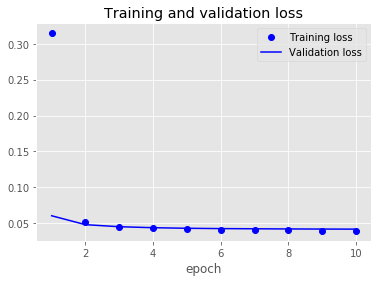

In [37]:
plot_training_history(history)

**2.2a** Explain what the embedding layer is and why we need it here.

Embeddings convert the given inputs indexes into dense vectors that perform better than sparse matrices that result from text being replaced by indices of unique words.

This heps improve performance since it also captures relationships between words as well.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

This is the number of inputs words - 35179 multiplied by the dimension of the embedding 50.

### Viewing Hidden Layers
In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that this code and the parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [38]:
FFNN = load_keras_model("model_FFNN")

def create_truncated_model_FFNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_te)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9409279770818937


In [39]:
# visualize hidden features on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te, axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

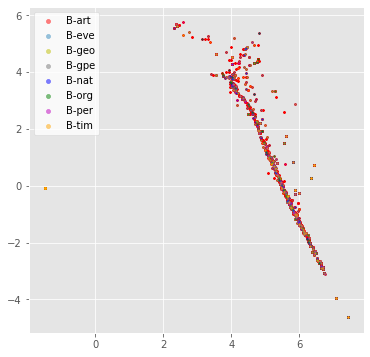

In [40]:
visualize_hidden_features(pca_result)

### Full function for other questions ###

In [41]:
def get_hidden_output_PCA(model,X_te,y_te,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [42]:
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.9409279042436339


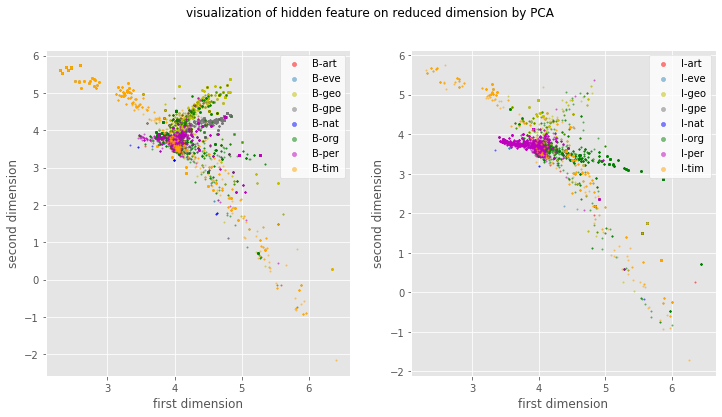

In [43]:
h = get_hidden_output_PCA(FFNN,X_te,y_te,1,50)
visualize_B_I(h)

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

In [44]:
# define model
model = Sequential()
model.add(Embedding(input_dim = n_words, output_dim = dim_embed, input_length = max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(100, return_sequences = True))
model.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))

# compile model
model.compile(optimizer = optimizer, loss = loss, metrics = metrics )

In [45]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 82s 2ms/sample - loss: 0.0911 - accuracy: 0.9778 - val_loss: 0.0327 - val_accuracy: 0.9903
Epoch 2/10
38846/38846 [==============================] - 81s 2ms/sample - loss: 0.0295 - accuracy: 0.9912 - val_loss: 0.0286 - val_accuracy: 0.9915
Epoch 3/10
38846/38846 [==============================] - 80s 2ms/sample - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.0281 - val_accuracy: 0.9916
Epoch 4/10
38846/38846 [==============================] - 80s 2ms/sample - loss: 0.0244 - accuracy: 0.9927 - val_loss: 0.0269 - val_accuracy: 0.9920
Epoch 5/10
38846/38846 [==============================] - 80s 2ms/sample - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0268 - val_accuracy: 0.9920
Epoch 6/10
38846/38846 [==============================] - 80s 2ms/sample - loss: 0.0222 - accuracy: 0.9934 - val_loss: 0.0264 - val_accuracy: 0.9921
Epoch 7/10
38846/38846 [==============================] -

In [46]:
# save your mode #
store_keras_model(model, 'model_RNN')

Saved model to disk


In [47]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_2 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 104, 100)          15100     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


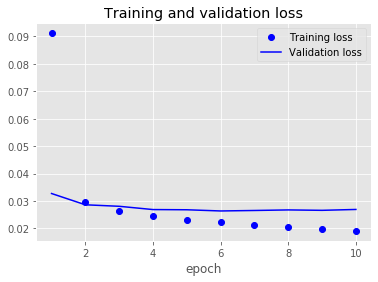

In [48]:
plot_training_history(history)

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

Variance explained by PCA: 0.9825275801918465


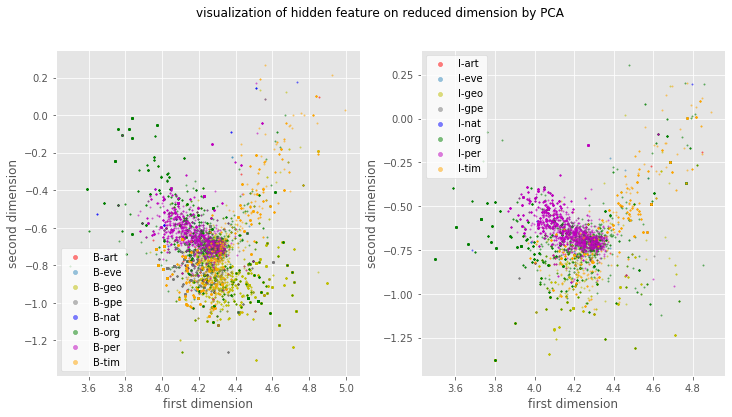

In [49]:
RNN = load_keras_model("model_RNN")

h = get_hidden_output_PCA(RNN,X_te,y_te,1,50)
visualize_B_I(h)

### Comment

* B-per and I-per tags appear to be dominating the PCA while other classes are overlapped. While the 1st 2 principal components explain 98% of the variation this could be on account of class unbalance.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

* GRU - Gradient Recurring Unit is a more sophisticated implementation of an RNN. 

* RNN has a simple hidden state while a GRU has a reset gate and an update gate. 

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

In [50]:
# define model
model = Sequential()
model.add(Embedding(input_dim = n_words, output_dim = dim_embed, input_length = max_len))
model.add(Dropout(drop_rate))
model.add(GRU(100, return_sequences = True))
model.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))

# compile model
model.compile(optimizer = optimizer, loss = loss, metrics = metrics )

In [51]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 45s 1ms/sample - loss: 0.0896 - accuracy: 0.9776 - val_loss: 0.0324 - val_accuracy: 0.9904
Epoch 2/10
38846/38846 [==============================] - 40s 1ms/sample - loss: 0.0290 - accuracy: 0.9914 - val_loss: 0.0283 - val_accuracy: 0.9916
Epoch 3/10
38846/38846 [==============================] - 40s 1ms/sample - loss: 0.0260 - accuracy: 0.9923 - val_loss: 0.0273 - val_accuracy: 0.9918
Epoch 4/10
38846/38846 [==============================] - 40s 1ms/sample - loss: 0.0242 - accuracy: 0.9928 - val_loss: 0.0264 - val_accuracy: 0.9922
Epoch 5/10
38846/38846 [==============================] - 40s 1ms/sample - loss: 0.0229 - accuracy: 0.9932 - val_loss: 0.0263 - val_accuracy: 0.9922
Epoch 6/10
38846/38846 [==============================] - 40s 1ms/sample - loss: 0.0219 - accuracy: 0.9935 - val_loss: 0.0256 - val_accuracy: 0.9924
Epoch 7/10
38846/38846 [==============================] -

In [52]:
# save your model #
store_keras_model(model, 'model_GRU')

Saved model to disk


In [53]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_3 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru (GRU)                    (None, 104, 100)          45600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,368
Trainable params: 1,806,368
Non-trainable params: 0
_________________________________________________________________
None


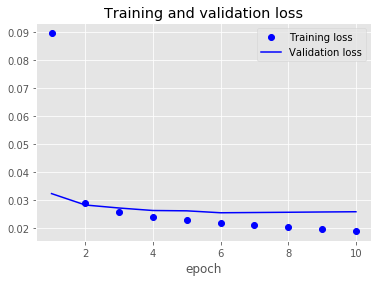

In [54]:
# run this cell to show your results #
plot_training_history(history)

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.9631177199204316


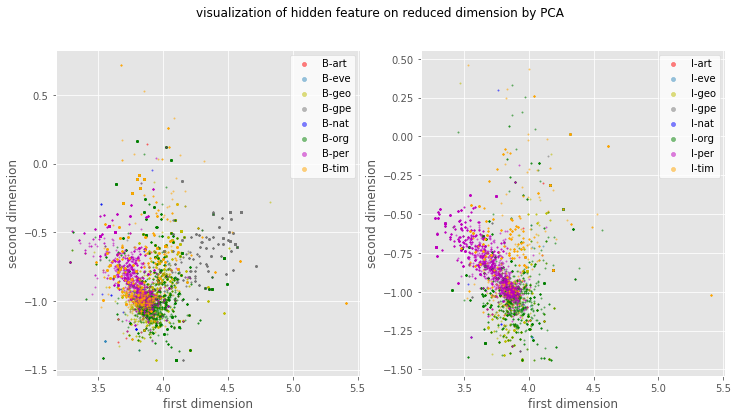

In [74]:
GRU = load_keras_model("model_GRU")

h = get_hidden_output_PCA(GRU,X_te,y_te,1,50)
visualize_B_I(h)

### Comment

* The modeal starts to overfit from training history chart.

* Variance explained by PCA drops to 96%

* Classes now appear to be more equally distributed for 'B' tags while the I-per tag still dominates. We believe that this could still be on account of the unbalanced which still needs to be addressed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.



Bidirectional GRU takes into account the previous input as well as the subsequent input. This is useful for cases such as language translation wherein we need the previous and subsequent words for context. 

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.


In [60]:
# define model
model = Sequential()
model.add(Embedding(input_dim = n_words, output_dim = dim_embed, input_length = max_len))
model.add(Dropout(drop_rate))
model.add(Bidirectional(GRU(100, return_sequences = True)))
model.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))

# compile model
model.compile(optimizer = optimizer, loss = loss, metrics = metrics )

In [61]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 76s 2ms/sample - loss: 0.0704 - accuracy: 0.9828 - val_loss: 0.0283 - val_accuracy: 0.9917
Epoch 2/10
38846/38846 [==============================] - 71s 2ms/sample - loss: 0.0242 - accuracy: 0.9929 - val_loss: 0.0239 - val_accuracy: 0.9929
Epoch 3/10
38846/38846 [==============================] - 71s 2ms/sample - loss: 0.0208 - accuracy: 0.9939 - val_loss: 0.0229 - val_accuracy: 0.9932
Epoch 4/10
38846/38846 [==============================] - 71s 2ms/sample - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0219 - val_accuracy: 0.9934
Epoch 5/10
38846/38846 [==============================] - 71s 2ms/sample - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.0218 - val_accuracy: 0.9935
Epoch 6/10
38846/38846 [==============================] - 71s 2ms/sample - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0215 - val_accuracy: 0.9935
Epoch 7/10
38846/38846 [==============================] -

In [62]:
# save your model #
store_keras_model(model, 'model_BiGRU')

Saved model to disk


In [63]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_5 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          91200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________
None


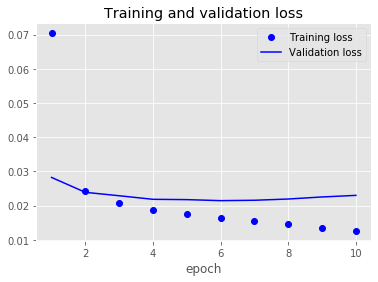

In [64]:
# run this cell to show your results #
plot_training_history(history)

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.8601710139604947


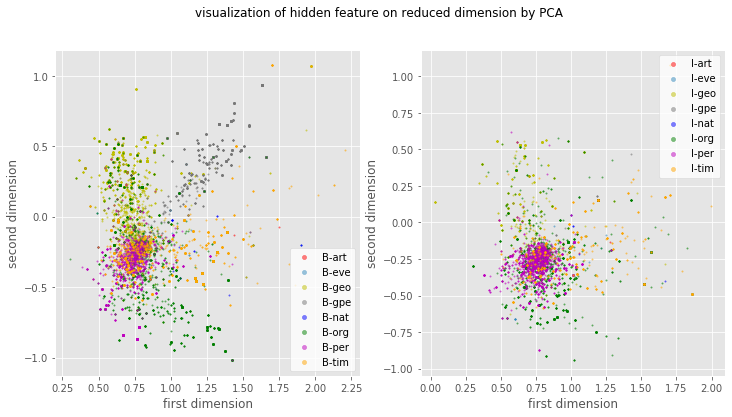

In [66]:
BGRU = load_keras_model("model_BiGRU")

h = get_hidden_output_PCA(BGRU,X_te,y_te,1,50)
visualize_B_I(h)

### Comment

* We can see from the plot_history that the model continues to overfit since the validation curve starts to curve upwards while the training curve is trending downwards.

* This is suppoerted by the fact that the overall variance explained by PCA also drops from the 90s in earlier charts to 86% here.

* From the PCA chart we see that the B-per tags are overlapping while hte I-per tag continues to dominate. 

* Values are also less spread out as compared to the previous charts.

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

**3.3** Briefly discuss the performance of each model


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.


## Answers

**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

In [67]:
# define lists for each model
# Have not listed the baseline model here since the question asks us to use the load_keras_model

f1_ffnn = []
f1_rnn = []
f1_gru = []
f1_bgru = []

f1_list = [f1_ffnn, f1_rnn, f1_gru, f1_bgru]
type(f1_list)

list

In [68]:
y_te_2d = np.argmax(y_te, axis = 2)
print(y_te_2d.shape)
print(y_te_2d[1])

(4796, 104)
[16 16 16 16  7 15 16 16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17]


In [69]:
# Note - I'm sure there is a better way to do this so any guidance here would be appreciated.

# https://stackoverflow.com/questions/33326704/scikit-learn-calculate-f1-in-multilabel-classification
from sklearn.preprocessing import MultiLabelBinarizer
m = MultiLabelBinarizer().fit(y_te_2d)

model_list = [item for item in os.listdir('./models/') if '.json' in item]

for i in range(len(model_list)):
    print(i)
    print(model_list[i][:-5])
    model = load_keras_model(model_list[i][:-5])
    pred = model.predict_classes(X_te, verbose = 1)
    print(pred.shape)
    f = f1_score(m.transform(y_te_2d), m.transform(pred), average = None)
    print(type(f), len(f))
    f1_list[i].append(f)
    print(type(f1_list[i]), len(f1_list[i]),'\n')

0
model_FFNN
4796/4796 [==============================] - 1s 115us/sample
(4796, 104)


/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<class 'numpy.ndarray'> 18
<class 'list'> 1 

1
model_RNN
4796/4796 [==============================] - 2s 409us/sample
(4796, 104)
<class 'numpy.ndarray'> 18
<class 'list'> 1 

2
model_GRU
4796/4796 [==============================] - 4s 870us/sample
(4796, 104)
<class 'numpy.ndarray'> 18
<class 'list'> 1 

3
model_BiGRU
4796/4796 [==============================] - 8s 2ms/sample
(4796, 104)
<class 'numpy.ndarray'> 18
<class 'list'> 1 



**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

In [70]:
f1_df = pd.DataFrame(list(zip(f1_ffnn[0].T, f1_rnn[0].T, f1_gru[0].T, f1_bgru[0].T)), columns = ['FFNN', 'RNN', 'GRU', 'BGRU'], index = tags)
print(f1_df.shape)
f1_df.head()

(18, 4)


,FFNN,RNN,GRU,BGRU
B-art,0.153846,0.114286,0.166667,0.055556
B-eve,0.488889,0.500000,0.488889,0.588235
B-geo,0.897196,0.909309,0.916650,0.927447
B-gpe,0.944882,0.953906,0.957878,0.964272
B-nat,0.648649,0.551724,0.518519,0.466667


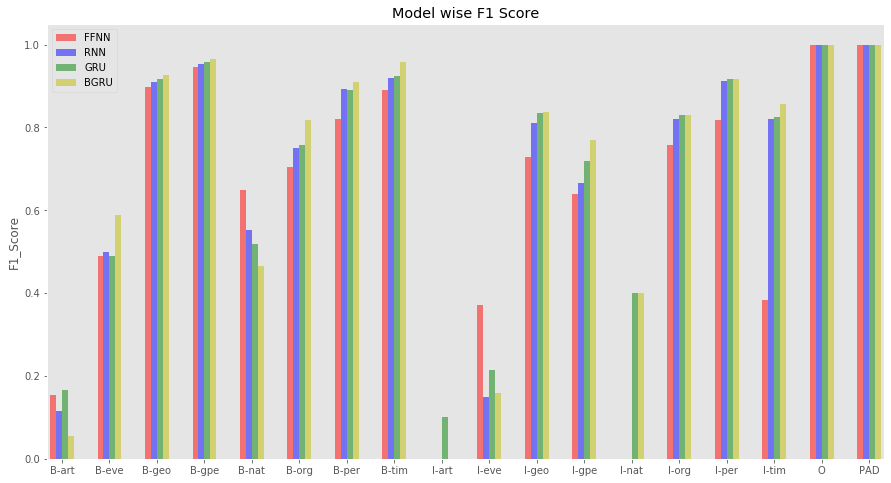

In [71]:
# https://chrisalbon.com/python/data_visualization/matplotlib_grouped_bar_plot/
# set posiiton and limits
width = 0.25
pos = np.arange(f1_df.shape[0])*2

# define the object create plot

fig, ax = plt.subplots(figsize=(15,8))
plt.bar(pos, f1_df.FFNN, width, alpha = 0.5, color = 'r')
plt.bar([p+width for p in pos], f1_df.RNN, width, alpha = 0.5, color = 'b')
plt.bar([p+width*2 for p in pos], f1_df.GRU, width, alpha = 0.5, color = 'g')
plt.bar([p+width*3 for p in pos], f1_df.BGRU, width, alpha = 0.5, color = 'y' )
    
# Set labels, ticks and other parameters
ax.set_ylabel('F1_Score')
ax.set_title('Model wise F1 Score')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(f1_df.index)
plt.xlim(min(pos)-width, max(pos)+width*4)

# Adding the legend and showing the plot
plt.legend(['FFNN', 'RNN', 'GRU', 'BGRU'], loc='best')
plt.grid()
plt.show()


**3.3** Briefly discuss the performance of each model

* All models have high accuray for most of the tags
* FFNN has low accuracy for I-art, I-nat and I-tim tags
* RNN and GRU have 0 values for I-art and I-nat tags
* We should try to fine tune a less complex model such as FFNN or RNN since the results are mostly similar.

**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

#### Comment

* B-art, I-art have the lowest scores
* I-eve and I-nat have higher scores than the tags above but the scores are much lower relative to the other tags.

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [72]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [75]:
# choose random x value and get word indexes
sample = 50
x_sample = X_te[sample]
#print(f'Shape of sample value: {x_sample.shape}')

x_sent = [x for x in x_sample if x != 35178] # remove padding
#print(len(x_sent), type(x_sent))

# get word from index
x_word = list(map(idx2word.get, x_sent))
#x_word

# define sample sentence output; get index values from vector and remove padding
y_sample = y_te[sample]
#print(y_sample.shape)
y_true = np.argmax(y_sample, axis = 1)
y_true = [y for y in y_true if y != 17]
#print(len(y_true), type(y_true))

# get baseline prediction
y_baseline = baseline[x_sent]
#len(y_baseline)

# get FFNN prediction
y_ffnn = FFNN.predict_classes(np.array(x_sample).reshape(1,-1))
y_ffnn = y_ffnn[0][:len(x_sent)]
#len(y_ffnn)

# get RNN prediction
y_rnn = RNN.predict_classes(np.array(x_sample).reshape(1,-1))
y_rnn = y_rnn[0][:len(x_sent)]
#len(y_rnn)

# get GRU prediction
y_gru = GRU.predict_classes(np.array(x_sample).reshape(1,-1))
y_gru = y_gru[0][:len(x_sent)]
#len(y_gru)

# get bidirectional GRU prediction
y_bgru = BGRU.predict_classes(np.array(x_sample).reshape(1,-1))
y_bgru = y_bgru[0][:len(x_sent)]
#len(y_bgru)

In [76]:
df2 = pd.DataFrame(list(zip(x_word, y_true, y_baseline, y_ffnn, y_rnn, y_gru, y_bgru)), columns = ['Word', 'y_true', 'y_baseline', 'y_ffnn', 'y_rnn', 'y_gru', 'y_bgru'])
print(df2.head())

df2[['y_true', 'y_baseline', 'y_ffnn', 'y_rnn', 'y_gru', 'y_bgru']] = df2[['y_true', 'y_baseline', 'y_ffnn', 'y_rnn', 'y_gru', 'y_bgru']].applymap(idx2tag.get)

df2.head()

        Word  y_true  y_baseline  y_ffnn  y_rnn  y_gru  y_bgru
0       They      16          13      16     16     16      16
1   released      16          16      16     16     16      16
2          a      16          16      16     16     16      16
3  statement      16          16      16     16     16      16
4       that      16          16      16     16     16      16


,Word,y_true,y_baseline,y_ffnn,y_rnn,y_gru,y_bgru
0,They,O,I-org,O,O,O,O
1,released,O,O,O,O,O,O
2,a,O,O,O,O,O,O
3,statement,O,O,O,O,O,O
4,that,O,O,O,O,O,O


In [77]:
df2.style.applymap(highlight_errors) #, axis = 1) #, inplace = True)
df2

,Word,y_true,y_baseline,y_ffnn,y_rnn,y_gru,y_bgru
0,They,O,I-org,O,O,O,O
1,released,O,O,O,O,O,O
2,a,O,O,O,O,O,O
3,statement,O,O,O,O,O,O
4,that,O,O,O,O,O,O
5,alleged,O,O,O,O,O,O
6,several,O,O,O,O,O,O
7,groups,O,O,O,O,O,O
8,",",O,O,O,O,O,O
9,including,O,O,O,O,O,O


**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

#### Approach

* We make 4 different attempts here
    * Increase dropout to 0.20
    * Increase dim_embed to 100
    * Add 1 layer of RNN and droput
    * Add didirectional RNN layer
* Earlystopping is also addedd to check overfitting
* f1_score plots for all attempts are also plotted at the end

#### Approach 1 - Increase dropout to 0.20

In [100]:
# Increase dropout to 0.20

n_units = 100
drop_rate = .20 # changed from 0.10 to 0.20
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [101]:
# define model
model = Sequential()
model.add(Embedding(input_dim = n_words, output_dim = dim_embed, input_length = max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(100, return_sequences = True)) 
#model.add(Dropout(drop_rate))
#model.add(SimpleRNN(50, return_sequences = True))
#model.add(Bidirectional(SimpleRNN(50, return_sequences = True)))
model.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))

# compile model
model.compile(optimizer = optimizer, loss = loss, metrics = metrics )


In [102]:
# earlystopping callback

callbacks = [ 
            EarlyStopping(
             # Stop training when `val_accuracy` is no longer improving
             monitor='val_accuracy',
             # "no longer improving" being further defined as "for at least 2 epochs"
             patience=2,
             verbose=1)
             ]

# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, callbacks = callbacks, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 83s 2ms/sample - loss: 0.0902 - accuracy: 0.9777 - val_loss: 0.0337 - val_accuracy: 0.9900
Epoch 2/10
38846/38846 [==============================] - 82s 2ms/sample - loss: 0.0307 - accuracy: 0.9909 - val_loss: 0.0292 - val_accuracy: 0.9913
Epoch 3/10
38846/38846 [==============================] - 82s 2ms/sample - loss: 0.0273 - accuracy: 0.9919 - val_loss: 0.0281 - val_accuracy: 0.9917
Epoch 4/10
38846/38846 [==============================] - 81s 2ms/sample - loss: 0.0256 - accuracy: 0.9925 - val_loss: 0.0270 - val_accuracy: 0.9919
Epoch 5/10
38846/38846 [==============================] - 81s 2ms/sample - loss: 0.0245 - accuracy: 0.9927 - val_loss: 0.0271 - val_accuracy: 0.9919
Epoch 6/10
38846/38846 [==============================] - 81s 2ms/sample - loss: 0.0235 - accuracy: 0.9931 - val_loss: 0.0264 - val_accuracy: 0.9922
Epoch 7/10
38846/38846 [==============================] -

In [103]:
pred = model.predict_classes(X_te, verbose = 0)
print(pred.shape)
f1_drop20 = f1_score(m.transform(y_te_2d), m.transform(pred), average = None)
f1_drop20.shape

(4796, 104)


/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(18,)

In [104]:
f1mod_df = pd.DataFrame(list(zip(f1_rnn[0].T, f1_drop20.T)), columns = ['RNN_base','Drop20'], index = tags)
print(f1mod_df.shape)
f1mod_df.head()

(18, 2)


,RNN_base,Drop20
B-art,0.114286,0.121212
B-eve,0.500000,0.500000
B-geo,0.909309,0.916155
B-gpe,0.953906,0.957713
B-nat,0.551724,0.518519


#### Approach 2 - Change dim_embed from 50 to 100

In [105]:
# change dim-embed from 50 to 100

n_units = 100
drop_rate = .10
dim_embed = 100 # 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [106]:
# define model
model = Sequential()
model.add(Embedding(input_dim = n_words, output_dim = dim_embed, input_length = max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(100, return_sequences = True)) 
#model.add(Dropout(drop_rate))
#model.add(SimpleRNN(50, return_sequences = True))
#model.add(Bidirectional(SimpleRNN(50, return_sequences = True)))
model.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))

# compile model
model.compile(optimizer = optimizer, loss = loss, metrics = metrics )


In [107]:
# earlystopping callback

callbacks = [ 
            EarlyStopping(
             # Stop training when `val_accuracy` is no longer improving
             monitor='val_accuracy',
             # "no longer improving" being further defined as "for at least 2 epochs"
             patience=2,
             verbose=1)
             ]

# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, callbacks = callbacks, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 95s 2ms/sample - loss: 0.0805 - accuracy: 0.9806 - val_loss: 0.0308 - val_accuracy: 0.9908
Epoch 2/10
38846/38846 [==============================] - 93s 2ms/sample - loss: 0.0276 - accuracy: 0.9917 - val_loss: 0.0277 - val_accuracy: 0.9918
Epoch 3/10
38846/38846 [==============================] - 93s 2ms/sample - loss: 0.0247 - accuracy: 0.9926 - val_loss: 0.0271 - val_accuracy: 0.9919
Epoch 4/10
38846/38846 [==============================] - 93s 2ms/sample - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.0262 - val_accuracy: 0.9922
Epoch 5/10
38846/38846 [==============================] - 93s 2ms/sample - loss: 0.0215 - accuracy: 0.9935 - val_loss: 0.0266 - val_accuracy: 0.9920
Epoch 6/10
38846/38846 [==============================] - 93s 2ms/sample - loss: 0.0201 - accuracy: 0.9939 - val_loss: 0.0265 - val_accuracy: 0.9920
Epoch 00006: early stopping


In [108]:
pred = model.predict_classes(X_te, verbose = 0)
print(pred.shape)
f1_embed100 = f1_score(m.transform(y_te_2d), m.transform(pred), average = None)
f1_embed100.shape

(4796, 104)


/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(18,)

In [109]:
f1mod_df['Embed100'] = f1_embed100
f1mod_df.head()

,RNN_base,Drop20,Embed100
B-art,0.114286,0.121212,0.105263
B-eve,0.500000,0.500000,0.511628
B-geo,0.909309,0.916155,0.910336
B-gpe,0.953906,0.957713,0.954829
B-nat,0.551724,0.518519,0.571429


#### Approach 3 - Add dropuout and simple RNN layers

In [110]:
n_units = 100
drop_rate = .10
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [111]:
# define model
model = Sequential()
model.add(Embedding(input_dim = n_words, output_dim = dim_embed, input_length = max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(100, return_sequences = True)) 
model.add(Dropout(drop_rate))
model.add(SimpleRNN(50, return_sequences = True))
#model.add(Bidirectional(SimpleRNN(50, return_sequences = True)))
model.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))

# compile model
model.compile(optimizer = optimizer, loss = loss, metrics = metrics )


In [112]:
# earlystopping callback

callbacks = [ 
            EarlyStopping(
             # Stop training when `val_accuracy` is no longer improving
             monitor='val_accuracy',
             # "no longer improving" being further defined as "for at least 2 epochs"
             patience=2,
             verbose=1)
             ]

# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, callbacks = callbacks, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 145s 4ms/sample - loss: 0.0815 - accuracy: 0.9797 - val_loss: 0.0322 - val_accuracy: 0.9906
Epoch 2/10
38846/38846 [==============================] - 142s 4ms/sample - loss: 0.0291 - accuracy: 0.9914 - val_loss: 0.0283 - val_accuracy: 0.9916
Epoch 3/10
38846/38846 [==============================] - 142s 4ms/sample - loss: 0.0259 - accuracy: 0.9924 - val_loss: 0.0281 - val_accuracy: 0.9915
Epoch 4/10
38846/38846 [==============================] - 142s 4ms/sample - loss: 0.0239 - accuracy: 0.9930 - val_loss: 0.0272 - val_accuracy: 0.9920
Epoch 5/10
38846/38846 [==============================] - 142s 4ms/sample - loss: 0.0226 - accuracy: 0.9933 - val_loss: 0.0272 - val_accuracy: 0.9921
Epoch 6/10
38846/38846 [==============================] - 143s 4ms/sample - loss: 0.0213 - accuracy: 0.9937 - val_loss: 0.0270 - val_accuracy: 0.9920
Epoch 7/10
38846/38846 [===========================

In [113]:
pred = model.predict_classes(X_te, verbose = 0)
print(pred.shape)
f1_dense_rnn = f1_score(m.transform(y_te_2d), m.transform(pred), average = None)
f1_dense_rnn.shape

(4796, 104)


/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(18,)

In [114]:
f1mod_df['denseRNN'] = f1_dense_rnn
f1mod_df.head()

,RNN_base,Drop20,Embed100,denseRNN
B-art,0.114286,0.121212,0.105263,0.000000
B-eve,0.500000,0.500000,0.511628,0.511628
B-geo,0.909309,0.916155,0.910336,0.914195
B-gpe,0.953906,0.957713,0.954829,0.956725
B-nat,0.551724,0.518519,0.571429,0.666667


#### Approach 4 - Add 1 Bidirectional layer

In [115]:
n_units = 100
drop_rate = .10
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [116]:
# define model
model = Sequential()
model.add(Embedding(input_dim = n_words, output_dim = dim_embed, input_length = max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(100, return_sequences = True)) 
model.add(Dropout(drop_rate))
#model.add(SimpleRNN(50, return_sequences = True))
model.add(Bidirectional(SimpleRNN(50, return_sequences = True)))
model.add(TimeDistributed(Dense(n_tags, activation = 'softmax')))

# compile model
model.compile(optimizer = optimizer, loss = loss, metrics = metrics )


In [124]:
# earlystopping callback

callbacks = [ 
            EarlyStopping(
             # Stop training when `val_accuracy` is no longer improving
             monitor='val_accuracy',
             # "no longer improving" being further defined as "for at least 2 epochs"
             patience=2,
             verbose=1)
             ]

# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, callbacks = callbacks, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 202s 5ms/sample - loss: 0.0177 - accuracy: 0.9948 - val_loss: 0.0231 - val_accuracy: 0.9932
Epoch 2/10
38846/38846 [==============================] - 201s 5ms/sample - loss: 0.0165 - accuracy: 0.9951 - val_loss: 0.0238 - val_accuracy: 0.9929
Epoch 3/10
38846/38846 [==============================] - 201s 5ms/sample - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.0237 - val_accuracy: 0.9931
Epoch 00003: early stopping


In [125]:
pred = model.predict_classes(X_te, verbose = 0)
print(pred.shape)
f1_bi_rnn = f1_score(m.transform(y_te_2d), m.transform(pred), average = None)
f1_bi_rnn.shape

(4796, 104)


(18,)

In [126]:
f1mod_df['BiD_RNN'] = f1_bi_rnn
f1mod_df.head()

,RNN_base,Drop20,Embed100,denseRNN,BiD_RNN
B-art,0.114286,0.121212,0.105263,0.000000,0.057143
B-eve,0.500000,0.500000,0.511628,0.511628,0.541667
B-geo,0.909309,0.916155,0.910336,0.914195,0.922357
B-gpe,0.953906,0.957713,0.954829,0.956725,0.962992
B-nat,0.551724,0.518519,0.571429,0.666667,0.518519


### Plot

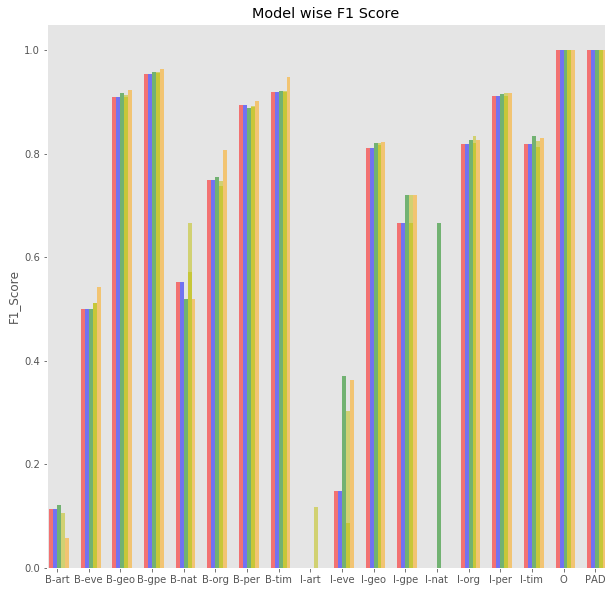

In [127]:
# https://chrisalbon.com/python/data_visualization/matplotlib_grouped_bar_plot/
# set posiiton and limits
width = 0.25
pos = np.arange(f1_df.shape[0])*2

# define the object create plot

fig, ax = plt.subplots(figsize=(10,10))
plt.bar(pos, f1mod_df.RNN_base, width, alpha = 0.5, color = 'r')
plt.bar([p+width for p in pos], f1mod_df.RNN_base, width, alpha = 0.5, color = 'b')
plt.bar([p+width*2 for p in pos], f1mod_df.Drop20, width, alpha = 0.5, color = 'g')
plt.bar([p+width*3 for p in pos], f1mod_df.Embed100, width, alpha = 0.5, color = 'y' )
plt.bar([p+width*3 for p in pos], f1mod_df.denseRNN, width, alpha = 0.5, color = 'y' )
plt.bar([p+width*4 for p in pos], f1mod_df.BiD_RNN, width, alpha = 0.5, color = 'orange' )

# Set labels, ticks and other parameters
ax.set_ylabel('F1_Score')
ax.set_title('Model wise F1 Score')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(f1_df.index)
plt.xlim(min(pos)-width, max(pos)+width*4)

# Adding the legend and showing the plot
#plt.legend(['RNN', 'Modified'], loc='best')
plt.grid()
plt.show()


**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.

#### Comment

* We make 4 different attempts here
    * Increase dropout to 0.20 - To explore if increased layers being dropped can bring focus to the unbalanced classes.
    * Increase dim_embed to 100 - More dense embeddings may bring deeper relationships to the fore
    * Add 1 layer of RNN and droput - More deep embeddings may bring deeper relationships to the fore
    * Add bidirectional RNN layer - Greater feedback from before and after to provide sentence context for beter tagging
* Earlystopping is also addedd to check overfitting


In [ ]:
# END